In [ ]:
import requests
import time
from datetime import datetime, timedelta
from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Fetch air pollution data from http://air.moepp.gov.mk/ from January 1, 2019 to January 15, 2021 for 6 monitoring stations in Skopje (Karpos, Centar, Gazi Baba, Lisice, Rektorat and Miladinovci). We have collected hourly data for each of the 6 measured pollutants - PM10, PM25, O3, CO, NO2, SO2. 

In [ ]:
pollutants = ['PM10', 'PM25', 'O3', 'CO', 'NO2', 'SO2']
stations = ['Karpos', 'Centar', 'GaziBaba', 'Lisice', 'Rektorat', 'Miladinovci']
date_start = datetime(2019, 1, 1, 0, 0, 0)
date_end = datetime(2021, 1, 16, 0, 0, 0)
period = timedelta(days=150)
offset = timedelta(seconds=1)

In [ ]:
sleep_time = 2
for station in stations:
  for pollutant in pollutants:
    results = []
    curr_start = deepcopy(date_start)
    while curr_start < date_end:
      try:
        time.sleep(1)
        curr_end = curr_start + period - offset
        print(curr_start.strftime("%d/%m/%Y, %H:%M:%S"), '-', curr_end.strftime("%d/%m/%Y, %H:%M:%S"), 
                     station, pollutant)
        
        URL = f'http://air.moepp.gov.mk/graphs/site/pages/MakeGraph.php?station={station}'+\
                      f'&parameter={pollutant}'+\
                      f'&beginDate={curr_start.strftime("%Y-%m-%d")}'+\
                      f'&beginTime={curr_start.strftime("%H:%M")}'+\
                      f'&endDate={curr_end.strftime("%Y-%m-%d")}'+\
                      f'&endTime={curr_end.strftime("%H:%M")}'+\
                      f'&i=1585697894082&lang=mk'

        curr_start += period

        req = requests.get(url=URL) 
        data = req.json()

        if 'measurements' not in data or len(data['measurements']) == 0 or 'data' not in data['measurements'][0]:
          continue

        measurements = data['measurements'][0]['data']
        timestamps = data['times']

        rows = list(zip(timestamps, measurements))
        results.extend(rows)

      except Exception as e:
        print(e)
        time.sleep(sleep_time)
        sleep_time += 1

    with open(f'pollution_raw_data/{station}_{pollutant}.csv', 'w+') as f:
      f.write('Timestamp,Value\n')
      for timestamp, value in results:
        f.write(f'{timestamp},{value}\n')

**Merge pollutants from a single station, replace None with np.nan**

In [ ]:
for station in stations:
  dataframes = []
  for pollutant in pollutants:
    df = pd.read_csv(f'./pollution_raw_data/{station}_{pollutant}.csv')
    df.Value = df.Value.apply(lambda x: np.float64(x) if x != 'None' else np.nan)
    df = df.set_index('Timestamp')
    df = df.rename(columns={"Value": pollutant})
    dataframes.append(df)

  df = pd.concat(dataframes, axis=1)
  df.to_csv(f'./merged_pollution_data/{station}.csv', index=True)

**Represent missing values**

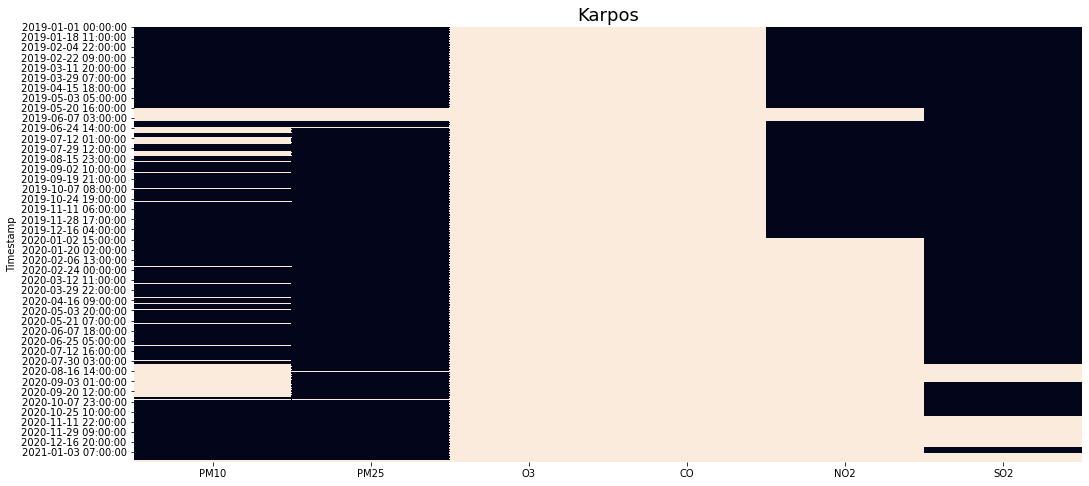

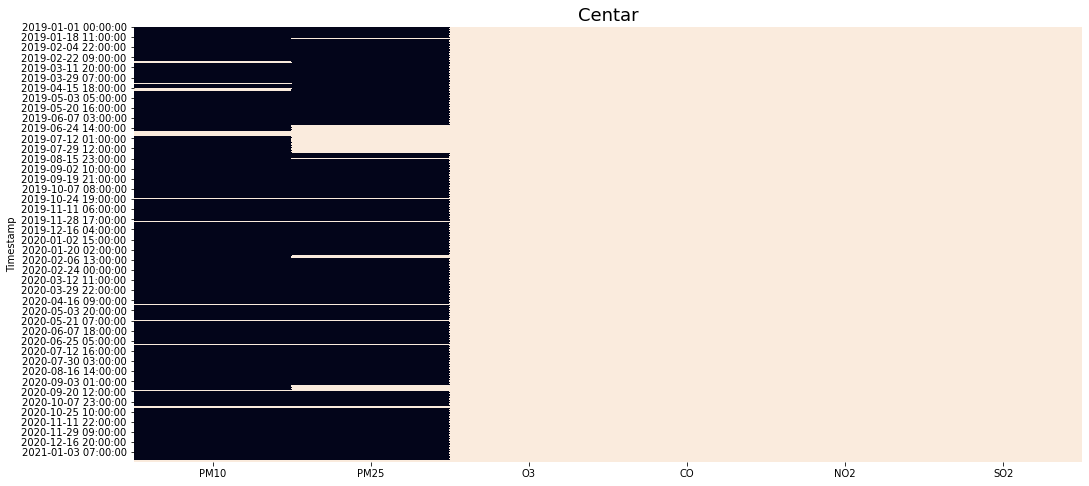

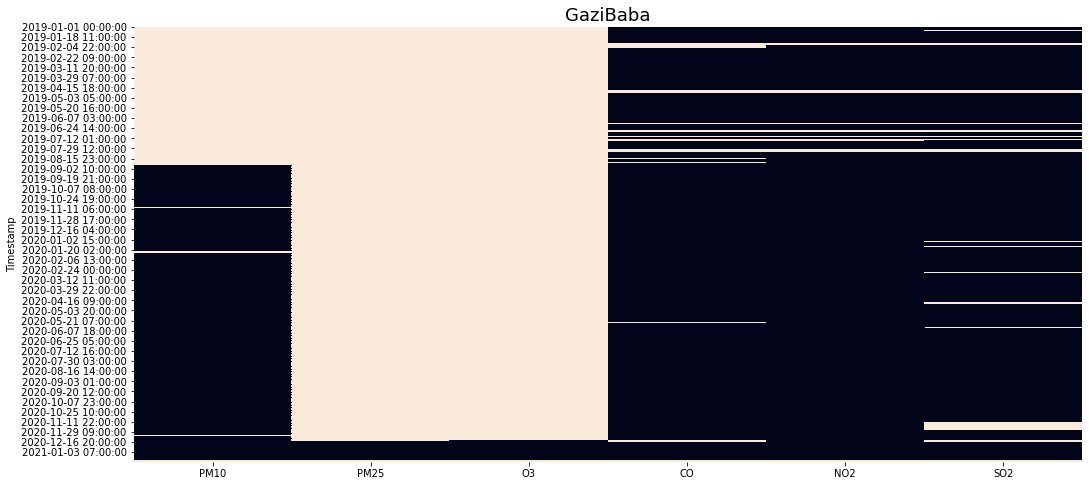

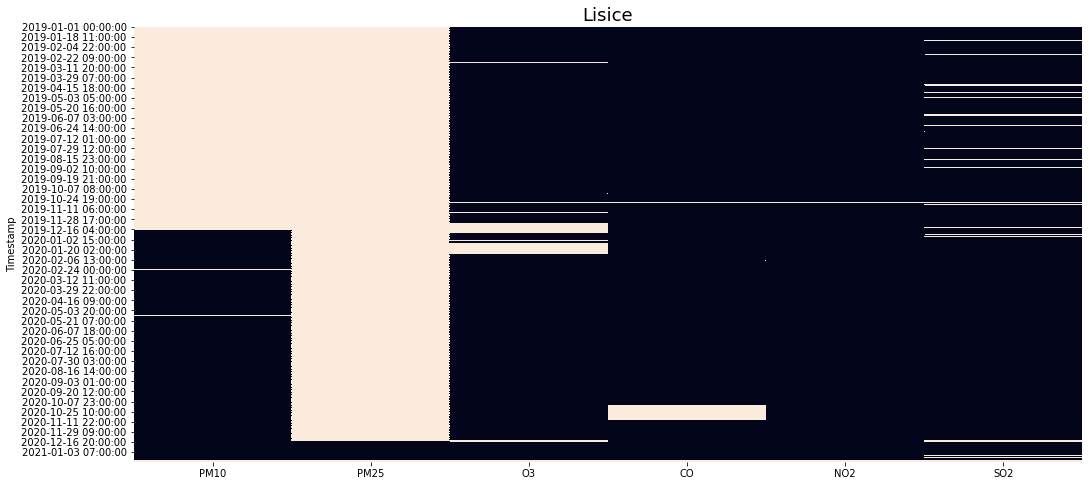

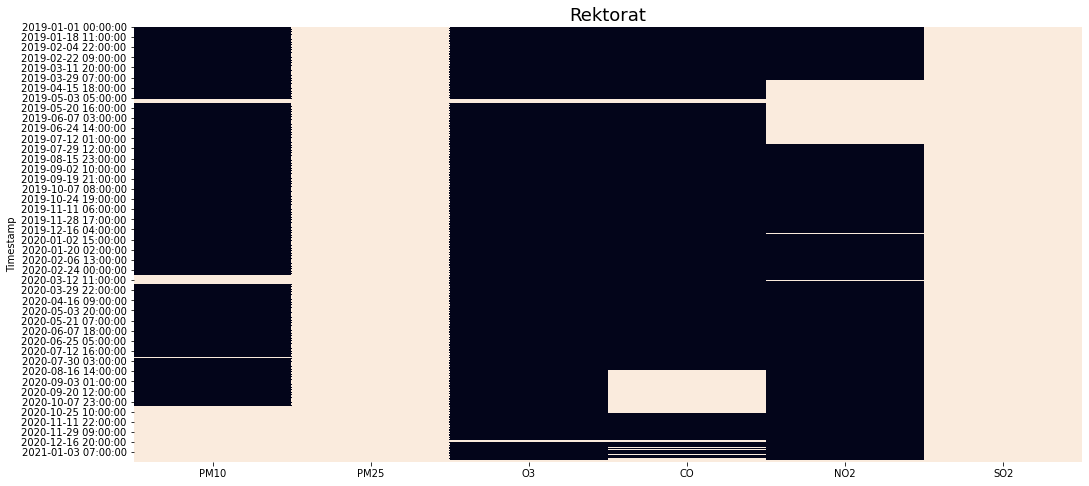

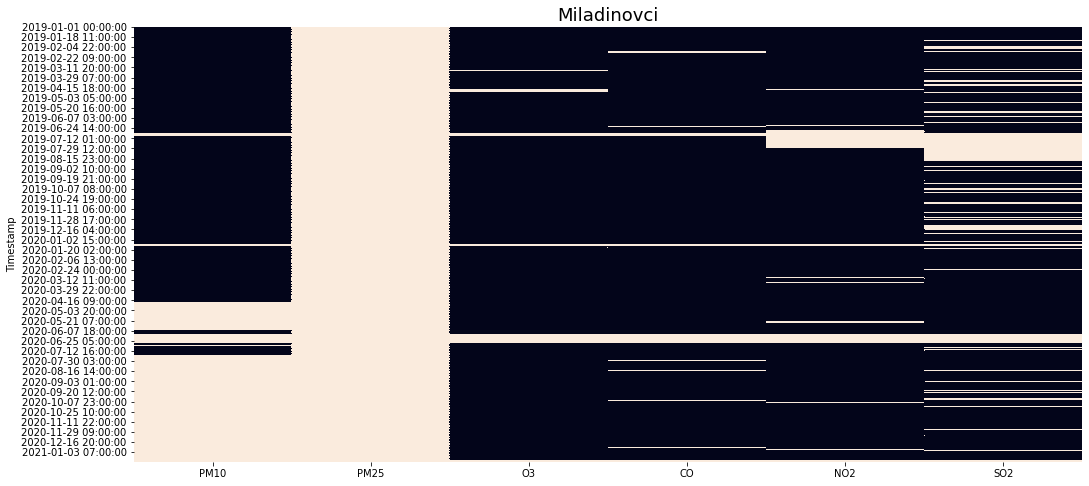

In [ ]:
for station in stations:
  df = pd.read_csv(f'./merged_pollution_data/{station}.csv', index_col=0)
  plt.figure(figsize=(20, 10))
  sns.heatmap(df.isnull(), cbar=False).set_title(f'{station}', fontsize=18)
  plt.show()

**Extract time data**

We have included data for the corresponding hour, day, month and year as separate attributes for the respective measurement. Also, we have provided information whether that day is a holiday or weekend, so later we can use it for comparison in our visualizations. Moreover these time features are helpful when we are dealing with time series like pollution data. 

In [ ]:
period = timedelta(hours=1)
# fixed holidays throughout the year
holidays = ['01.01', '06.01', '07.01', '19.01', '01.05', '24.05', '02.08', '28.08', '08.09', '11.10', '23.10', '08-12']
curr_date = deepcopy(date_start)
data = {}

while curr_date <= date_end:
  timestamp = curr_date.strftime("%Y-%m-%d %H:%M:%S")
  hour = curr_date.hour
  day = curr_date.day
  month = curr_date.month
  year = curr_date.year
  weekend = 1 if day == 6 or day == 7 else 0
  holiday = 1 if curr_date.strftime("%d.%m") in holidays else 0
  data[timestamp] = (hour, day, month, year, weekend, holiday)
  curr_date += period

df = pd.DataFrame.from_dict(data, orient='index', columns=['hour', 'day', 'month', 'year', 'weekend', 'holiday'])
df.index.name = 'Timestamp'
df.to_csv('./merged_pollution_data/time.csv', index=True)
df.head(25)

,hour,day,month,year,weekend,holiday
Timestamp,,,,,,
2019-01-01 00:00:00,0,1,1,2019,0,1
2019-01-01 01:00:00,1,1,1,2019,0,1
2019-01-01 02:00:00,2,1,1,2019,0,1
2019-01-01 03:00:00,3,1,1,2019,0,1
2019-01-01 04:00:00,4,1,1,2019,0,1
2019-01-01 05:00:00,5,1,1,2019,0,1
2019-01-01 06:00:00,6,1,1,2019,0,1
2019-01-01 07:00:00,7,1,1,2019,0,1
2019-01-01 08:00:00,8,1,1,2019,0,1


**Dropped missing pollutants from pollution datasets**

**Karpos**

In [ ]:
df = pd.read_csv('./merged_pollution_data/Karpos.csv', index_col=0)
df.head()

,PM10,PM25,O3,CO,NO2,SO2
Timestamp,,,,,,
2019-01-01 00:00:00,23.530600,15.444100,NaN,NaN,6.8624,0.4560
2019-01-01 01:00:00,28.213699,19.989700,NaN,NaN,6.3512,0.4863
2019-01-01 02:00:00,28.874300,20.497299,NaN,NaN,7.4539,0.3608
2019-01-01 03:00:00,30.247200,20.952600,NaN,NaN,6.7862,0.4143
2019-01-01 04:00:00,26.500401,18.163700,NaN,NaN,7.4280,0.5343


In [ ]:
df = df.drop(['O3', 'CO'], axis=1)
df.to_csv('./final_pollution_data/Karpos.csv', index=True)
df.shape

(17904, 4)

In [ ]:
df.isnull().sum(axis=0)

PM10    3324
PM25     642
NO2     9692
SO2     2328
dtype: int64

**Centar**

In [ ]:
df = pd.read_csv('./merged_pollution_data/Centar.csv', index_col=0)
df.head()

,PM10,PM25,O3,CO,NO2,SO2
Timestamp,,,,,,
2019-01-01 00:00:00,15.324900,8.4704,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,22.204800,10.6802,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,21.212500,10.2108,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,24.841900,10.4952,NaN,NaN,NaN,NaN
2019-01-01 04:00:00,21.795099,9.4589,NaN,NaN,NaN,NaN


In [ ]:
df = df.drop(['O3', 'CO', 'NO2', 'SO2'], axis=1)
df.to_csv('./final_pollution_data/Centar.csv', index=True)
df.shape

(17904, 2)

In [ ]:
df.isnull().sum(axis=0)

PM10     923
PM25    1971
dtype: int64

**Gazi Baba**

In [ ]:
df = pd.read_csv('./merged_pollution_data/GaziBaba.csv', index_col=0)
df.head()

,PM10,PM25,O3,CO,NO2,SO2
Timestamp,,,,,,
2019-01-01 00:00:00,NaN,NaN,NaN,0.3248,3.1515,2.7132
2019-01-01 01:00:00,NaN,NaN,NaN,0.3132,2.9032,5.2668
2019-01-01 02:00:00,NaN,NaN,NaN,0.2668,2.4448,2.5270
2019-01-01 03:00:00,NaN,NaN,NaN,0.3016,4.5458,2.2344
2019-01-01 04:00:00,NaN,NaN,NaN,0.2088,3.3425,1.9950


In [ ]:
df = df.drop(['PM25', 'O3'], axis=1)
df.to_csv('./final_pollution_data/GaziBaba.csv', index=True)
df.shape

(17904, 4)

In [ ]:
df.isnull().sum(axis=0)

PM10    5861
CO       845
NO2      575
SO2     1304
dtype: int64

**Lisice**

In [ ]:
df = pd.read_csv('./merged_pollution_data/Lisice.csv', index_col=0)
df.head()

,PM10,PM25,O3,CO,NO2,SO2
Timestamp,,,,,,
2019-01-01 00:00:00,NaN,NaN,11.040000,0.2784,18.947201,2.0482
2019-01-01 01:00:00,NaN,NaN,19.440001,0.1508,11.440900,2.5270
2019-01-01 02:00:00,NaN,NaN,18.139999,0.1740,14.535100,2.6068
2019-01-01 03:00:00,NaN,NaN,18.379999,0.2320,15.490100,2.5004
2019-01-01 04:00:00,NaN,NaN,16.639999,0.2552,16.731600,2.4472


In [ ]:
df = df.drop(['PM25'], axis=1)
df.to_csv('./final_pollution_data/Lisice.csv', index=True)
df.shape

(17904, 5)

In [ ]:
df.isnull().sum(axis=0)

PM10    8512
O3      1147
CO       803
NO2      155
SO2      780
dtype: int64

**Rektorat**

In [ ]:
df = pd.read_csv('./merged_pollution_data/Rektorat.csv', index_col=0)
df.head()

,PM10,PM25,O3,CO,NO2,SO2
Timestamp,,,,,,
2019-01-01 00:00:00,54.879902,NaN,7.22,0.8584,53.403400,NaN
2019-01-01 01:00:00,64.399902,NaN,4.94,1.0440,56.459801,NaN
2019-01-01 02:00:00,52.250000,NaN,7.42,0.8352,36.500301,NaN
2019-01-01 03:00:00,53.849998,NaN,4.38,0.9396,50.424000,NaN
2019-01-01 04:00:00,61.590000,NaN,7.50,0.7308,36.385502,NaN


In [ ]:
df = df.drop(['PM25', 'SO2'], axis=1)
df.to_csv('./final_pollution_data/Rektorat.csv', index=True)
df.shape

(17904, 4)

In [ ]:
df.isnull().sum(axis=0)

PM10    2780
O3       303
CO      2154
NO2     2734
dtype: int64

**Miladinovci**

In [ ]:
df = pd.read_csv('./merged_pollution_data/Miladinovci.csv', index_col=0)
df.head()

,PM10,PM25,O3,CO,NO2,SO2
Timestamp,,,,,,
2019-01-01 00:00:00,34.389999,NaN,30.240000,0.5220,9.8747,3.2186
2019-01-01 01:00:00,40.419998,NaN,28.540001,0.4176,9.4927,4.4422
2019-01-01 02:00:00,21.360001,NaN,35.820000,0.2088,6.2457,3.8570
2019-01-01 03:00:00,21.260000,NaN,27.920000,0.2900,7.7355,3.3250
2019-01-01 04:00:00,29.129999,NaN,16.559999,0.3364,11.4218,3.2186


In [ ]:
df = df.drop(['PM25'], axis=1)
df.to_csv('./final_pollution_data/Miladinovci.csv', index=True)
df.shape

(17904, 5)

In [ ]:
df.isnull().sum(axis=0)

PM10    6102
O3       840
CO       947
NO2     1608
SO2     3522
dtype: int64